In [10]:
from typing import List, Mapping
from itertools import zip_longest, chain
from glob import iglob
from pickle import load
from functools import partial, reduce

from numba import jit
from scipy.ndimage.filters import gaussian_filter
import pandas as pd
import numpy as np
from numpy.random import normal, choice, rand
from numpy.polynomial.legendre import Legendre
import matplotlib.pyplot as plt
from h5py import File

from vmitools import (
    abel_inverse, finite_legendre_transform_in_theta,
    interp, tohist, transpose_linearly, transpose_to_drdomega, transpose_to_drdth,
    mrot, mhorshear, msqueeze,
)

In [5]:
filenames = [
    "/data/Step501N2/combined/274-283/274-283_1_66.h5",
]

In [22]:
def read_file(filename):
    try:
        with File(filename, "r") as f:
            imgs = f['/vmi/data'][...].astype('float')
            n = f['/signal_shots'][...]
            delays = f['/IR_delays'][...]
            atmax = f['/peak_wavelengths'][...]
            i0, i1, ix, iy = imgs.shape
            indexes = (delays * atmax.T).reshape(-1)
    except KeyError:
        print("Got an error at: {}".format(filename))
        return None
    ret = pd.DataFrame({
        'sum': [img for img in (imgs * n[:, :, None, None]).reshape(-1, ix, iy)],
        'count': n.reshape(-1),
    }, index=pd.MultiIndex.from_product(
        [delays.reshape(-1), atmax.reshape(-1)],
        names=['delay_float', 'atmax_float'],
    ))
    where = ret['count'] != 0
    return ret[where]


sumup = partial(reduce, partial(pd.DataFrame.add, fill_value=0))
summed_flatten = sumup(read_file(fn) for fn in filenames)
summed_flatten.reset_index(inplace=True)

,,sum,count
delays,atmax,,
-7.800024,80.657844,"[[2445.0407673860996, 3917.633093525188, 1937....",1666.0
-7.775407,80.657844,"[[2081.8679471788705, 2691.112845138064, 1457....",1667.0
-7.750791,80.657844,"[[2561.003605769229, 2962.927884615372, 1992.1...",1667.0
-7.726175,80.657844,"[[2015.850374064838, 2749.2019950124554, 2062....",1607.0
-7.701559,80.657844,"[[1998.9999999999804, 2142.999999999987, 1918....",1606.0
-7.676943,80.657844,"[[2285.8847874720427, 2291.936241610758, 2000....",1787.0
-7.652327,80.657844,"[[2244.1535580524287, 2652.352059925108, 2322....",1599.0
-7.627711,80.657844,"[[2239.7493796525973, 2276.300248138949, 1787....",1614.0
-7.603094,80.657844,"[[3570.258343634078, 4042.362793572309, 3068.9...",3237.0


In [25]:
@jit
def bin_delays(d):
    step = 0.02  # Check delay step!
    centers = np.arange(-10, 0, step)
    bins = (centers[1:] + centers[:-1]) / 2
    return centers.item(np.digitize(d, bins=bins))


@jit
def bin_atmax(d):
    step = 0.02  # Check delay step!
    centers = np.arange(75, 85, step)
    bins = (centers[1:] + centers[:-1]) / 2
    return centers.item(np.digitize(d, bins=bins))


summed_flatten['delay'] = summed_flatten['delay_float'].apply(bin_delays)
summed_flatten['atmax'] = summed_flatten['atmax_float'].apply(bin_atmax)
summed_all = summed_flatten.groupby(['delay', 'atmax'])[['sum', 'count']].apply(sum)
summed_all[['count']]

,,img,n
delays,atmax,,
-7.800,80.657844,"[[1.467611505033673, 1.229720665244514, 1.2505...",1666.0
-7.775,80.657844,"[[1.2488709941085006, 1.0334744575694685, 1.21...",1667.0
-7.750,80.657844,"[[1.5362949044806413, 1.6528706277975118, 1.27...",1667.0
-7.725,80.657844,"[[1.2544184032761905, 1.6893981598586123, 1.33...",1607.0
-7.700,80.657844,"[[1.2447073474470614, 1.65255292652553, 1.0491...",1606.0
-7.675,80.657844,"[[1.2791744753620833, 1.1936343640185356, 1.41...",1787.0
-7.650,80.657844,"[[1.4034731444980793, 1.6386388496555637, 1.38...",1599.0
-7.625,80.657844,"[[1.3877009787190813, 1.0761236205534033, 1.29...",1614.0
-7.600,80.657844,"[[1.1029528401711701, 1.3128774487509816, 0.94...",3237.0


In [ ]:
ind = summed_all.index[10][1]
print(f"Choosed {ind}")
summed = summed_all.loc[pd.IndexSlice[:, ind], :]
summed

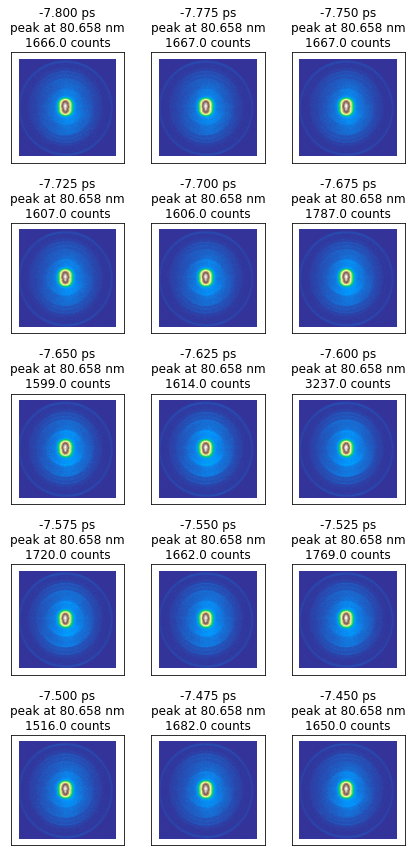

In [29]:
plt.figure(figsize=(6, 12))
for i, ((dt, atmax), img, n) in enumerate(df[['img', 'n']].itertuples()):
    if 15 <= i:
        break
    plt.subplot(5, 3, i+1)
    plt.title(f"{dt:.3f} ps\npeak at {atmax:.3f} nm\n{n} counts")
    plt.pcolormesh(img.T, cmap='terrain')
    plt.axis("equal")
    plt.xticks([], [])
    plt.yticks([], [])
    plt.clim(0, None)
plt.tight_layout()
plt.show()

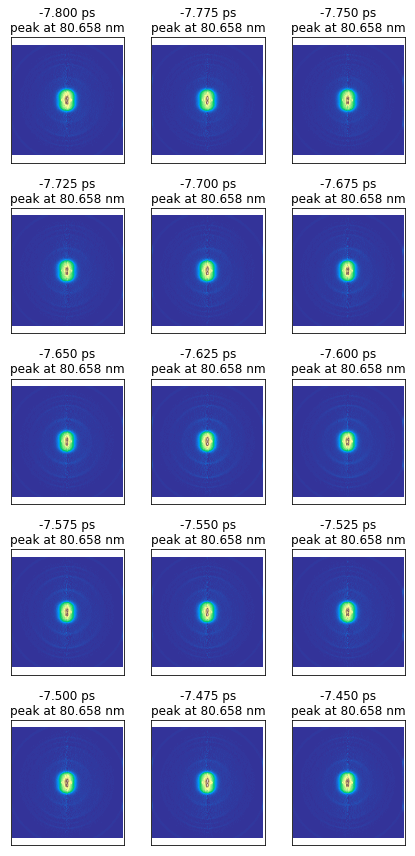

In [30]:
zedges = np.arange(-400, 400 + 1)
redges, thedges = np.linspace(0, 400, 400 + 1), np.linspace(-np.pi, np.pi, 360 + 1)
r = (redges[1:] + redges[:-1]) / 2
th = (thedges[1:] + thedges[:-1]) / 2


def invert_img(d):
    img = d['img']
    img = gaussian_filter(img, 2)
    xn, yn = img.shape
    xedges = np.arange(xn + 1)
    yedges = np.arange(yn + 1)
    f = interp(img, xedges, yedges)
    g = transpose_linearly(f, np.eye(2), x0=np.array([437, 458]))
    transformed = tohist(g, zedges, zedges)

    dz = zedges[1:] - zedges[:-1]
    inverted = abel_inverse(transformed, zedges) * dz[None, :]  # shape: (r, z)
    sliced = interp(inverted, zedges, zedges)  # (rho, z) -> intensity
    hist_indrdomega = tohist(transpose_to_drdomega(sliced), redges, thedges)  # (r, th) -> intensity
    hist_indrdth = tohist(transpose_to_drdth(sliced), redges, thedges)  # (r, th) -> intensity
    return pd.Series({
        'inverted': inverted,
        'hist_indrdth': hist_indrdth,
        'hist_indrdomega': hist_indrdomega,
    })


if 'inverted' in df:
    df = df.drop(columns=['inverted', 'hist_indrdth', 'hist_indrdomega'])
df = df.merge(df.apply(invert_img, axis=1), left_index=True, right_index=True)


plt.figure(figsize=(6, 12))
for i, ((dt, atmax), img, n) in enumerate(df[['inverted', 'n']].itertuples()):
    if 15 <= i:
        break
    plt.subplot(5, 3, i+1)
    plt.title(f"{dt:.3f} ps\npeak at {atmax:.3f} nm")
    plt.pcolormesh(img.T, cmap='terrain')
    plt.axis("equal")
    plt.xticks([], [])
    plt.yticks([], [])
    plt.clim(0, None)
plt.tight_layout()
plt.show()

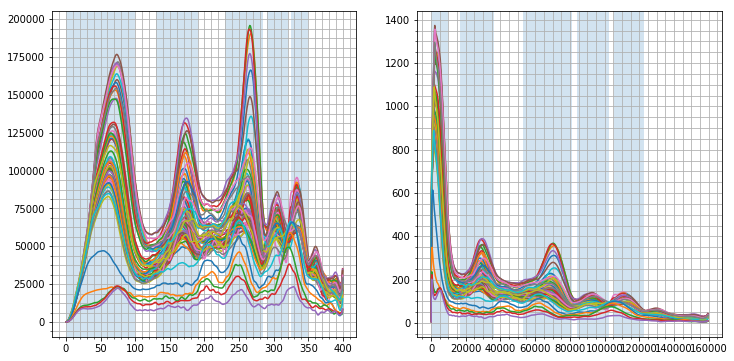

In [46]:
roi = [
    [0, 100],
    [130, 190],
    [230, 285],
    [290, 320],
    [325, 350],
]


def f(hist):
    return hist.sum(1)


def intergrateit(hist, fr, to, x=None, **kwargs):
    if x is None:
        x = np.arange(len(hist))
    where = (fr < x) & (x < to)
    return hist[where].sum(**kwargs)


def project_to_pn(hist, n):
    _, coeff, _ = finite_legendre_transform_in_theta(
        hist, thedges, n + 1,
    )  # Shapes of returns: (n, r) (n, r) (n, th)
    return coeff[n]/coeff[0]


for i, (fr, to) in enumerate(roi):
    df[f'summed{i}_rdist'] = df['hist_indrdth'].apply(intergrateit, fr=fr, to=to, x=r)
    df[f'summed{i}_pad'] = df['hist_indrdomega'].apply(intergrateit, fr=fr, to=to, x=r, axis=0)
    df[f'summed{i}_beta2'] = df[f'summed{i}_pad'].apply(project_to_pn, n=2)
    df[f'summed{i}_beta4'] = df[f'summed{i}_pad'].apply(project_to_pn, n=4)


plt.figure(figsize=(12, 6))
plt.subplot(121)
for (dt, atmax), dist in df['hist_indrdth'].apply(f).items():
    plt.plot(r, dist, label=f"delay={dt:.3f},atmax={atmax:.3f}")
plt.minorticks_on()
plt.grid(True, which='both')

for fr, to in roi:
    plt.axvspan(fr, to, alpha=0.2)

plt.subplot(122)
for (dt, atmax), dist in df['hist_indrdth'].apply(f).items():
    plt.plot(r**2, dist/2/r, label=f"delay={dt:.3f}, atmax={atmax}")
plt.minorticks_on()
plt.grid(True, which='both')

for fr, to in roi:
    plt.axvspan(fr**2, to**2, alpha=0.2)

# plt.legend()
plt.show()

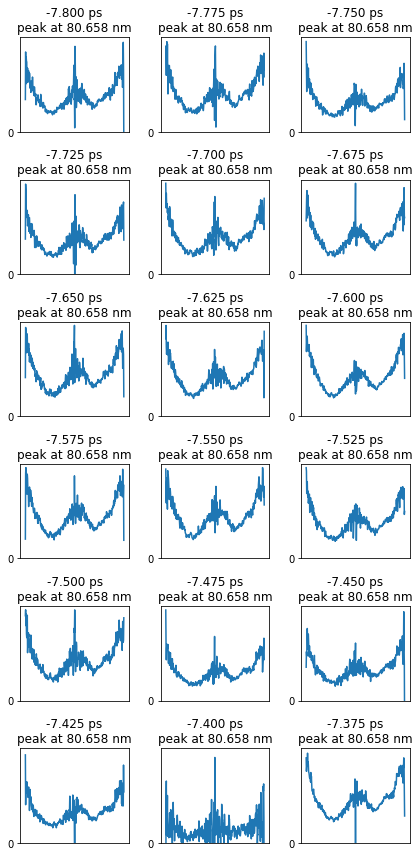

In [39]:
plt.figure(figsize=(6, 12))
for i, ((dt, atmax), pad) in enumerate(df['summed2_pad'].items()):
    if 18 <= i:
        break
    plt.subplot(6, 3, i+1)
    plt.title(f"{dt:.3f} ps\npeak at {atmax:.3f} nm")
    plt.plot(th, pad)
    plt.xticks([], [])
    plt.yticks([0], [0])
    plt.ylim(0, None)
plt.tight_layout()
plt.show()

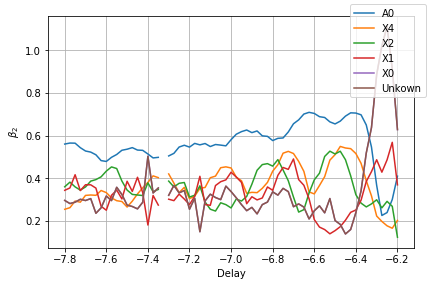

In [48]:
dropped = df.reset_index(level=1, drop=True)


def norm(arr):
    return arr/arr.sum()


plt.figure()
plt.xlabel("Delay")
plt.ylabel(r"$\beta_2$")
plt.plot(dropped['summed0_beta2'], label='A0')
plt.plot(dropped['summed1_beta2'], label='X4')
plt.plot(dropped['summed2_beta2'], label='X2')
plt.plot(dropped['summed3_beta2'], label='X1')
plt.plot(dropped['summed4_beta2'], label='X0')
plt.plot(dropped['summed4_beta2'], label='Unkown')
# plt.ylim(0, None)
plt.grid(True)
plt.figlegend()
plt.tight_layout()
plt.show()

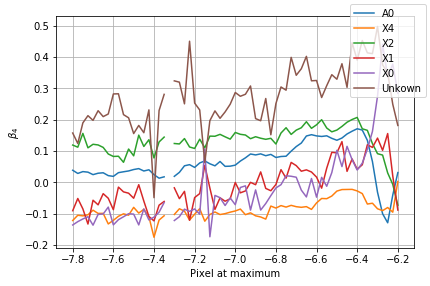

In [49]:
def norm(arr):
    return arr/arr.sum()


plt.figure()
plt.xlabel("Pixel at maximum")
plt.ylabel(r"$\beta_4$")
plt.plot(dropped['summed0_beta4'], label='A0')
plt.plot(dropped['summed1_beta4'], label='X4')
plt.plot(dropped['summed2_beta4'], label='X2')
plt.plot(dropped['summed3_beta4'], label='X1')
plt.plot(dropped['summed4_beta4'], label='X0')
plt.plot(dropped['summed5_beta4'], label='Unkown')
# plt.ylim(0, None)
plt.grid(True)
plt.figlegend()
plt.tight_layout()
plt.show()

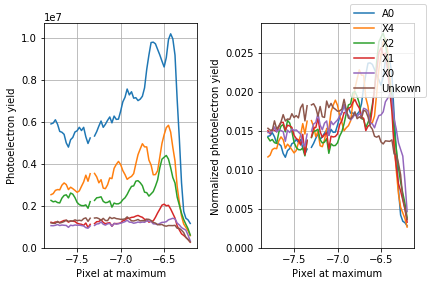

In [50]:
def norm(arr):
    return arr/arr.sum()


plt.figure()
plt.subplot(121)
plt.xlabel("Pixel at maximum")
plt.ylabel("Photoelectron yield")
plt.plot(dropped['summed0_rdist'], label='A0')
plt.plot(dropped['summed1_rdist'], label='X4')
plt.plot(dropped['summed2_rdist'], label='X2')
plt.plot(dropped['summed3_rdist'], label='X1')
plt.plot(dropped['summed4_rdist'], label='X0')
plt.plot(dropped['summed5_rdist'], label='Unkown')
plt.ylim(0, None)
plt.grid(True)
plt.figlegend()

plt.subplot(122)
plt.xlabel("Pixel at maximum")
plt.ylabel("Normalized photoelectron yield")
plt.plot(norm(dropped['summed0_rdist']), label='A0')
plt.plot(norm(dropped['summed1_rdist']), label='X4')
plt.plot(norm(dropped['summed2_rdist']), label='X2')
plt.plot(norm(dropped['summed3_rdist']), label='X1')
plt.plot(norm(dropped['summed4_rdist']), label='X0')
plt.plot(norm(dropped['summed5_rdist']), label='Unkown')
plt.ylim(0, None)
plt.grid(True)
# plt.figlegend()
plt.tight_layout()
plt.show()